# Test site effects of the subtypes
Take ABIDE and test for site effects

In [1]:
# Imports
import os
import glob
import scipy
import numpy as np
import pandas as pd
import nibabel as nib
import statsmodels.api as sm
from scipy import stats as st
from scipy import cluster as scl
from matplotlib import pyplot as plt
from statsmodels import stats as stm
from statsmodels.sandbox import stats as sts
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

## Set up the paths

In [3]:
# Paths
scale = 12
subtypes = 5
name = 'n308_sample'
mtp_list= ['rmap_part', 'dual_regression', 'stability_maps']

prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
in_path = '/data1/subtypes/serial_preps/'

mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'

## Build the subtypes

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

## Prepare GLM

In [6]:
# Generate the model matrix
factors = ['SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = pheno.ix[:,factors]
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

In [7]:
comp_list = list()
for mtp in mtp_list:
    netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
    corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
    
    # Load the serialized netstack
    netstack = np.load(netstack_path)
    corr_mat = np.load(corrmat_path)
    
    scale = netstack.shape[0]
    n_sub = netstack.shape[2]
    n_vox = netstack.shape[1]
    
    link_store = np.zeros((n_sub-1,4,scale))
    part_store = np.zeros((scale, n_sub))
    sbt_store = np.zeros((scale, subtypes, n_vox))
    weight_store = np.zeros((scale, subtypes, n_sub))
    
    # Iterate through the networks
    for net_id in range(scale):
        # Compute linkage with Ward's criterion
        link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
        link_store[..., net_id] = link_mat
        # Partition the linkage to get a given number of subtypes
        part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
        part_store[net_id, :] = part_sub

        sub_stack = np.zeros((n_vox, subtypes))
        for s_id in range(subtypes):
            sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
            sub_stack[:,s_id] = sbt
            sbt_store[net_id, s_id, :] = sbt

        # Init store - Compute the weights
        for s_id in range(subtypes):
            type_map = sub_stack[:, s_id]
            weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])
            
    # Compute effect sizes
    r2_store = np.zeros((scale, subtypes))
    for net_id in range(scale):
        # Loop through the subtypes
        for s_id in range(subtypes):
            # Full model
            full_model = sm.OLS(weight_store[net_id, s_id, :], glm_pheno)
            full_results = full_model.fit()
            SSR = np.sum(np.square(full_results.resid.values))
            # Restricted model
            rest_model = sm.OLS(weight_store[net_id, s_id, :], glm_pheno.ix[:,factors[0]:])
            rest_results = rest_model.fit()
            # Save the p-values
            SST = np.sum(np.square(rest_results.resid.values))
            # Find the improvement of the sum of squares from including sites
            SSM = SST - SSR
            r2 = SSM / SST
            r2_store[net_id, s_id] = r2
    comp_list.append(r2_store)

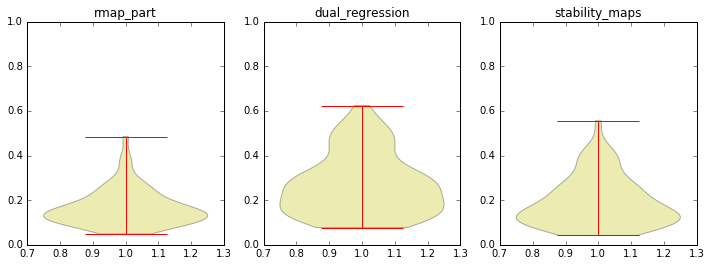

In [8]:
# Visualize the results
fig = plt.figure(figsize=(12,4))
for m_id, m_name in enumerate(mtp_list):
    res = comp_list[m_id]
    ax = fig.add_subplot(1,3,m_id+1)
    ax.violinplot(res.flatten())
    ax.set_ylim([0, 1])
    ax.set_title(m_name)

# Do a descriptive analysis of site differences
Take a look at the distribution of:

1. subtype weights across the sites
* Subjects across sites
* ASD and TDC cases across sites
* Motion and sex across sites

In [28]:
glm_pheno.head()

,INTERCEPT,MAX_MUN,NYU,OHSU,OLIN,PITT,SDSU,UCLA_1,UCLA_2,USM,SEX,AGE_AT_SCAN,FD_scrubbed
0,1,0,0,0,0,0,0,0,0,0,2,-0.417629,0.169546
1,1,0,0,0,0,0,0,0,0,0,2,-0.417629,0.196809
2,1,0,0,0,0,0,0,0,0,0,1,0.882371,0.199631
3,1,0,0,0,0,0,0,0,0,0,1,-0.017629,0.240001
4,1,0,0,0,0,0,0,0,0,0,1,2.382371,0.184871


In [9]:
pgp = pheno.groupby('SITE_ID')

In [38]:
a = pgp.FD_scrubbed.value_counts()